In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import svm

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib-3.0.0-py3.7-macosx-10.9-x86_64.egg/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Read dataset

In [2]:
df = pd.read_csv('train.csv.gz', sep=',').dropna()
dest = pd.read_csv('destinations.csv.gz')
df = df.sample(frac=0.01, random_state=99)
df.shape

(241179, 24)

In [3]:
df.head(5)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
32352134,2014-05-22 11:40:07,2,3,66,174,24103,2323.5232,802499,0,1,...,0,1,1442,3,0,1,4,125,177,44
29796021,2013-06-29 12:24:37,2,3,66,311,25538,2288.6121,85229,0,0,...,1,1,8272,1,0,1,2,50,659,59
15185156,2014-10-30 13:58:32,2,3,66,294,40046,587.6970,755217,0,1,...,0,1,11321,1,0,1,2,50,642,22
3301948,2014-08-22 20:14:34,2,3,66,332,55121,2234.4394,160733,0,1,...,0,1,1152,1,1,1,4,47,1502,65
25429119,2014-03-25 18:47:43,2,3,66,314,47869,839.0087,1078493,0,0,...,0,1,8284,1,0,4,2,50,685,6


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.9-x86_64.egg/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


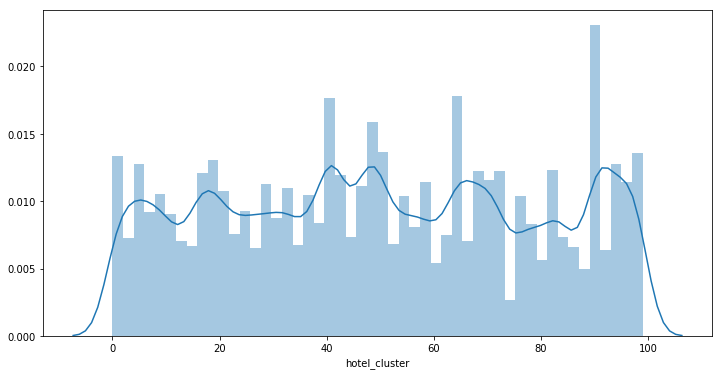

In [4]:
plt.figure(figsize=(12, 6))
sns.distplot(df['hotel_cluster'])

# Helper function to extract datetime

In [5]:
from datetime import datetime
def get_year(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').year
        except ValueError:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year
    else:
        return 2013
    pass        

In [6]:
def get_month(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').month
        except:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month
    else:
        return 1
    pass

In [7]:
def left_merge_dataset(left_dframe, right_dframe, merge_column):
    return pd.merge(left_dframe, right_dframe, on=merge_column, how='left')


In [8]:
# extract datetime from dataframe
df['date_time_year'] = pd.Series(df.date_time, index = df.index)
df['date_time_month'] = pd.Series(df.date_time, index = df.index)
from datetime import datetime
df.date_time_year = df.date_time_year.apply(lambda x: get_year(x))
df.date_time_month = df.date_time_month.apply(lambda x: get_month(x))
# delete it from dataframe
del df['date_time']

In [9]:
# dealing with srch_ci column which is checkin data
df['srch_ci_year'] = pd.Series(df.srch_ci, index=df.index)
df['srch_ci_month'] = pd.Series(df.srch_ci, index=df.index)
# convert year & months to int
df.srch_ci_year = df.srch_ci_year.apply(lambda x: get_year(x))
df.srch_ci_month = df.srch_ci_month.apply(lambda x: get_month(x))
# remove the srch_ci column
del df['srch_ci']


In [10]:
# dealing with search checkout date column
df['srch_co_year'] = pd.Series(df.srch_co, index=df.index)
df['srch_co_month'] = pd.Series(df.srch_co, index=df.index)
# convert year & months to int
df.srch_co_year = df.srch_co_year.apply(lambda x: get_year(x))
df.srch_co_month = df.srch_co_month.apply(lambda x: get_month(x))
# remove the srch_co column
del df['srch_co']


# sort features by it's important

In [11]:
df.corr()["hotel_cluster"].sort_values()

srch_destination_type_id    -0.036120
site_name                   -0.027497
hotel_country               -0.023837
is_booking                  -0.022898
user_location_country       -0.020239
srch_destination_id         -0.016736
srch_co_month               -0.005874
srch_rm_cnt                 -0.005570
srch_ci_month               -0.005015
date_time_month             -0.002142
channel                     -0.001386
date_time_year              -0.000435
cnt                          0.000378
hotel_continent              0.000422
user_location_city           0.001241
user_id                      0.003891
orig_destination_distance    0.006084
user_location_region         0.006927
srch_ci_year                 0.008562
is_mobile                    0.008788
srch_co_year                 0.009287
posa_continent               0.012180
srch_adults_cnt              0.012407
srch_children_cnt            0.014901
hotel_market                 0.022149
is_package                   0.047598
hotel_cluste

# Create cluster based on features:
- Search destination for user 
- Hotel country
- Hotel market

In [12]:
# combinations of search destinations, hotel country, hotel market
pieces = [df.groupby(['srch_destination_id','hotel_country','hotel_market','hotel_cluster'])['is_booking'].agg(['sum','count'])]
agg = pd.concat(pieces).groupby(level=[0,1,2,3]).sum()
agg.dropna(inplace=True)
agg.head()

sum  count
srch_destination_id hotel_country hotel_market hotel_cluster            
4                   7             246          22               0      1
                                               29               0      1
                                               30               0      1
                                               32               1      2
                                               43               0      1

In [13]:
agg['sum_and_cnt'] = 0.85*agg['sum'] + 0.15*agg['count']
agg = agg.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
agg.reset_index(inplace=True)
agg.head()


,srch_destination_id,hotel_country,hotel_market,hotel_cluster,sum,count,sum_and_cnt
0,4,7,246,22,0.0,0.125,0.073171
1,4,7,246,29,0.0,0.125,0.073171
2,4,7,246,30,0.0,0.125,0.073171
3,4,7,246,32,1.0,0.250,0.560976
4,4,7,246,43,0.0,0.125,0.073171


In [14]:
agg_pivot = agg.pivot_table(index=['srch_destination_id','hotel_country','hotel_market'], columns='hotel_cluster', values='sum_and_cnt').reset_index()
agg_pivot.head()


hotel_cluster,srch_destination_id,hotel_country,hotel_market,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,4,7,246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,50,416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.025210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11,50,824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14,27,1434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16,50,419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.344828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df = pd.merge(df, dest, how='left', on='srch_destination_id')
df = pd.merge(df, agg_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])
df.fillna(0, inplace=True)
df.shape


(241179, 276)

In [16]:
df.head(5)

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,90,91,92,93,94,95,96,97,98,99
0,2,3,66,174,24103,2323.5232,802499,0,1,9,...,0.000000,0.000000,0.000000,0.064103,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1,2,3,66,311,25538,2288.6121,85229,0,0,9,...,0.014629,0.062696,0.014890,0.014368,0.025340,0.017241,0.049112,0.0,0.0,0.021160
2,2,3,66,294,40046,587.6970,755217,0,1,9,...,0.068263,0.067066,0.000000,0.076647,0.000000,0.000000,0.000000,0.0,0.0,0.000000
3,2,3,66,332,55121,2234.4394,160733,0,1,9,...,0.010283,0.000000,0.002571,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.005141
4,2,3,66,314,47869,839.0087,1078493,0,0,9,...,0.034261,0.049251,0.000000,0.010707,0.002141,0.000000,0.075660,0.0,0.0,0.019272


In [17]:
# check booking events only
df = df.loc[df['is_booking'] == 1]

In [18]:
# extract labels and features from dataframe
X = df.drop(['user_id', 'hotel_cluster', 'is_booking'], axis=1).astype(float)
y = df.hotel_cluster.astype(float)

In [19]:
X.head(5)

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_adults_cnt,...,90,91,92,93,94,95,96,97,98,99
3,2.0,3.0,66.0,332.0,55121.0,2234.4394,0.0,1.0,9.0,2.0,...,0.010283,0.000000,0.002571,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.005141
9,34.0,3.0,205.0,135.0,27655.0,234.6637,0.0,0.0,5.0,4.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
20,13.0,1.0,46.0,157.0,34868.0,612.4875,0.0,0.0,9.0,2.0,...,0.010125,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.028447,0.0,0.026037
41,2.0,3.0,66.0,337.0,6988.0,943.0843,0.0,0.0,2.0,2.0,...,0.011082,0.043272,0.001583,0.0,0.0,0.038522,0.021636,0.000000,0.0,0.001583
62,13.0,1.0,46.0,347.0,38786.0,611.3314,0.0,0.0,9.0,3.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000


In [20]:
y.head(5)

3     65.0
9     63.0
20     8.0
41    71.0
62    85.0
Name: hotel_cluster, dtype: float64

# Algorithms : The idea here is to classify the users based on matching them with another people from different clusters and calcaute the accuracy for every model
- Naive bayes
- K-Nearest Neighbors Classifier
- Random Forest Classifier
- Multi-class Logistic Regression
- SVM

## TODO : Add latent features such as number of images , context for this hotel booking e.g is this hotel booking increases in specific time or not when you should visit it etc .
### Hint : Deep neural network can improve this result also

#### Naive Bayes

In [21]:
from sklearn.naive_bayes import GaussianNB
clf = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors=None))
np.mean(cross_val_score(clf, X, y, cv=10))

0.10347912437041926

### K-Nearest Neighbors Classifier

In [22]:
from sklearn.neighbors import KNeighborsClassifier
clf = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=5))
np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy'))

0.25631461834732266

### Random Forest Classifier

In [23]:
clf = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(n_estimators=273,max_depth=10,random_state=0))
np.mean(cross_val_score(clf, X, y, cv=10))

0.24865023372782996

### Multi-class Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
clf = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(multi_class='ovr'))
np.mean(cross_val_score(clf, X, y, cv=10))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scikit_learn-0.20.0-py3.7-macosx-10.9-x86_64.egg/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scikit_learn-0.20.0-py3.7-macosx-10.9-x86_64.egg/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scikit_learn-0.20.0-py3.7-macosx-10.9-x86_64.egg/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scikit_learn-0.20.0-py3.7-macosx-10.9-x86_64.egg/skl

0.30445543572367767

### SVM Classifier

In [25]:
from sklearn import svm
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(decision_function_shape='ovo'))
np.mean(cross_val_score(clf, X, y, cv=10))

0.3228727137315005